In [6]:
import tensorflow as ts
from tensorflow import keras
import numpy as np
import tensorflow.keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.callbacks import Callback

def custom_loss(y_true, y_pred,t,beta, e, x0, T,gamma):
    """
    Calculates the L2 norm of the difference between y_pred and a constant value, plus
    a scaled sum of y_pred, for each example in the batch. Returns the average L2 norm
    over all examples.

    Args:
    y_true: tensor of true labels
    y_pred: tensor of predicted labels

    Returns:
    A tensor representing the mean L2 norm over all examples.
    """
    
     # calculate the difference y_pred[i] - c * sum(y_pred)
    n = K.int_shape(y_pred)[1]
    hs = T / n
    aux = e*beta*(T-t)*(gamma-beta*e*x0)
    aux2 = hs*K.cumsum(y_pred, axis=1)
    aux3 = hs*(K.sum(aux2, axis=1,keepdims=True)-K.cumsum(aux2, axis=1))

    diff = y_pred-aux+beta*beta*e*e*aux3
    
    # calculate the L2 norm for each example
    norma = K.sqrt(K.sum(K.square(diff), axis=1))
    
    # return the average L2 norm over all training examples
    return K.mean(norma)





class SavePredictions(Callback):
    def __init__(self, x_val):
        self.x_val = x_val
        self.predictions = []
    
    def on_epoch_end(self, epoch, logs={}):
        # Faz as previsões no conjunto de validação
        y_pred = self.model.predict(self.x_val)
        
        # Salva as previsões em uma lista
        self.predictions.append(y_pred)
        
        # Salva as previsões em um arquivo a cada 5 épocas
        if epoch % 10 == 0:
            np.save('solutions/predictions_ex2_epoch{}.npy'.format(10000+epoch), y_pred)

def trimf(x,a,b,c):
    rs = np.nan
    if x<a or x>c:
        rs = 0
    elif x>=a and x<=b:
        rs = (x-a)/(b-a)
    elif x>b and x<=c:
        rs = (c-x)/(c-b)
    return rs

def dinamica(u,x,t,T):
    tv = np.space(0,T,len(u))
    hs = tv[1]
    aux = np.interp(t,tv,hs*np.cumsum(u))
    return x+aux,x-aux

def construir_sol(t,z,u,fuz):
    rs = np.zeros(shape=(len(z),len(t)))
    u = t[1]*np.cumsum(u)
    for i,vt in enumerate(t):
        for j,vz in enumerate(z):
            rs[j,i] = trimf(vz-u[i],fuz[0],fuz[1],fuz[2])
    return rs



In [ ]:
# parâmetros
gamma, beta, e, x0, T = 1.0, 1.0, 1.0, 5.0, 1.0

# Tamanho da entrada, número de neurônios nas camadas ocultas
n, n1, n2 = 100, 5, 5


# Dados de treinamento
X_train = np.linspace(0,T,n).reshape(1,n)
y_train = np.linspace(0,T,n).reshape(1,n)

# Criação do modelo
model = Sequential()

# Adicionando as camadas ao modelo
model.add(InputLayer(input_shape=(n,)))
model.add(Dense(n1, activation='relu'))
model.add(Dense(n2, activation='relu'))
model.add(Dense(n, activation='linear'))

# Compilando o modelo
loss = lambda y_true, y_pred: custom_loss(y_true, y_pred, np.linspace(0,T,n), beta, e, x0, T,gamma)
model.compile(loss=loss, optimizer='adam')


# Treinando o modelo
save_predictions = SavePredictions(X_train)
model.fit(X_train, y_train, epochs=1001, callbacks=[save_predictions])

# model.fit(X_train, y_train, epochs=2001)

# Fazendo uma previsão
y_pred = model.predict(X_train).ravel()

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import io

# Define o número de iterações
directory = os.getcwd()
extensao = ".npy"
files = os.listdir(os.path.join(directory, "solutions"))

filtered_files = sorted([file for file in files if file.endswith(extensao) and "_ex2_" in file])
num_iter = len(filtered_files)

# Cria uma lista para armazenar as imagens em memória
images = []

# Loop pelas iterações
for i in range(num_iter):
    data = np.load("solutions/"+filtered_files[i])
    # Cria os dados do gráfico
    x = np.linspace(0, 1,n)
    y = data.ravel()
    
    # Cria a figura e o eixo
    fig, ax = plt.subplots()
    sns.lineplot(x=x, y=y, ax=ax)
    ax.set(xlim=[0,1],ylim=[-3,1])
    ax.set_xlabel(r'$t$',fontsize=16,usetex=True)
    ax.set_ylabel(r'$u(t)$',fontsize=16,usetex=True)

    
    # Adiciona o número da iteração no canto superior direito
    ax.text(0.95, 0.95, f'Iteração: {i}', transform=ax.transAxes, ha='right', va='top')
    
    # Salva a figura em memória como uma imagem
    buffer = io.BytesIO()
    plt.savefig(buffer, format='png', dpi=300)
    buffer.seek(0)
    image = Image.open(buffer)
    images.append(image)
    
    # Fecha a figura
    plt.close()

# Salva o GIF a partir das imagens em memória
images[0].save('animacao_ex2.gif',
               save_all=True,
               append_images=images[1:],
               duration=100,
               loop=0)

# Apaga os arquivos numpy
# for file in filtered_files:
#     os.unlink(file)

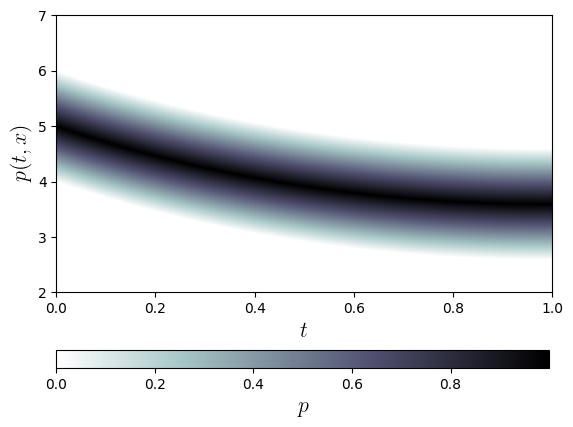

In [122]:
import matplotlib.pyplot as plt

gamma, beta, e, x0, T = 1.0, 1.0, 1.0, 5.0, 1.0
u = np.load("solutions/predictions_ex2_epoch11000.npy").ravel()
t = np.linspace(0, T, len(u))
z = np.linspace(2, x0 + 2 * e, 500)
T, Z = np.meshgrid(t, z)
M = construir_sol(t, z, u, [x0 - e, x0, x0 + e])

fig, ax = plt.subplots(figsize=(6.4,0.75*4.8)) # Define o tamanho da figura como 6 por 4

# Ajuste os limites da imagem para ocupar a maior área possível dentro da figura
im = ax.imshow(M, extent=[t.min(), t.max(), z.min(), z.max()], cmap='bone_r', origin='lower', aspect='auto')

ax.set_xlabel(r'$t$', fontsize=16, usetex=True)
ax.set_ylabel(r'$p(t,x)$', fontsize=16, usetex=True)

pos = ax.get_position()

cax = fig.add_axes([pos.x0, -0.1, pos.height, 0.05])
cbar = fig.colorbar(im, cax=cax,orientation='horizontal')
cbar.set_label(r'$p$', fontsize=16, usetex=True)

plt.show()


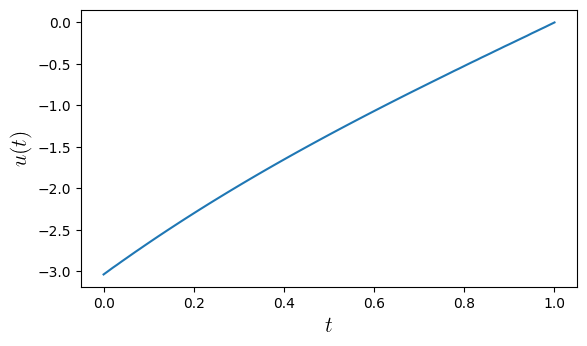

In [95]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(6.4,0.75*4.8))
pl = sns.lineplot(x=t,y=u)
ax.set_xlabel(r'$t$',fontsize=16,usetex=True)
ax.set_ylabel(r'$u(t)$',fontsize=16,usetex=True)
pos = ax.get_position()


In [118]:
[6.4,0.75*4.8]


[6.4, 3.5999999999999996]